In [ ]:
import tensorflow as tf

In [ ]:
import shutil
import random
import os


base_dir = "/kaggle/input/dog-and-cat-classification-dataset/PetImages"  # Correct path
working_dir = "/kaggle/working/dog-cat-classification"  # Working directory


train_dir_new = os.path.join(working_dir, 'train')
val_dir_new = os.path.join(working_dir, 'validation')

os.makedirs(train_dir_new, exist_ok=True)
os.makedirs(val_dir_new, exist_ok=True)
os.makedirs(os.path.join(train_dir_new, 'dog'), exist_ok=True)
os.makedirs(os.path.join(train_dir_new, 'cat'), exist_ok=True)
os.makedirs(os.path.join(val_dir_new, 'dog'), exist_ok=True)
os.makedirs(os.path.join(val_dir_new, 'cat'), exist_ok=True)

In [ ]:

for category in ['Dog', 'Cat']:
    category_path = os.path.join(base_dir, category)  # Path to 'Dog' and 'Cat' folders
    files = os.listdir(category_path)
    random.shuffle(files)

    split = int(0.8 * len(files))  # 80% for training
    train_files = files[:split]
    val_files = files[split:]


    for f in train_files:
        shutil.copy(os.path.join(category_path, f), os.path.join(train_dir_new, category.lower(), f))
    for f in val_files:
        shutil.copy(os.path.join(category_path, f), os.path.join(val_dir_new, category.lower(), f))

In [ ]:
print(f"Train folder: {train_dir_new}")
print(f"Validation folder: {val_dir_new}")

Train folder: /kaggle/working/dog-cat-classification/train
Validation folder: /kaggle/working/dog-cat-classification/validation


 Data Augmentation Using ImageDataGenerator

- Images are resized to **160 × 160**.
- Batch size is set to **64**.

### Training Data Augmentation:
- Rescaling (1./255)
- Rotation
- Width & Height Shift
- Shear
- Zoom
- Horizontal Flip

### Validation Data:
- Only rescaling is applied.

This helps improve model generalization and reduce overfitting.

---

In [ ]:


from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = (160, 160)  # Resize images for VGG16
BATCH_SIZE = 64


train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir_new,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
    val_dir_new,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

Found 24036 images belonging to 2 classes.
Found 9038 images belonging to 2 classes.


 Load Pre-trained VGG16 Model (Transfer Learning)

- Pre-trained **VGG16** model is loaded with:
  - `weights='imagenet'`
  - `include_top=False`
- The top classification layer is removed.
- The base model is frozen initially (`trainable = False`).

### Custom Layers Added:
- GlobalAveragePooling2D
- Dense layer (512 neurons, ReLU)
- Dropout (0.5)
- Output Dense layer (1 neuron, Sigmoid activation)

Sigmoid activation is used for **binary classification (Dog vs Cat)**.

In [ ]:


from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models


base_model = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)
)

base_model.trainable = False


model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')  # Binary classification (dog vs cat)
])


model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Print the model summary
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 5, 5, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,977,857 (57.14 MB)

 Trainable params: 263,169 (1.00 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

## Phase 1


In [ ]:

# Step 6: Train the Model (Phase 1: Train the top layers only)
history1 = model.fit(
    train_generator,
    epochs=7,
    validation_data=val_generator
)

Epoch 1/7
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 534ms/step - accuracy: 0.6508 - loss: 0.6140

/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


376/376 ━━━━━━━━━━━━━━━━━━━━ 255s 630ms/step - accuracy: 0.6510 - loss: 0.6138 - val_accuracy: 0.8541 - val_loss: 0.3749
Epoch 2/7
376/376 ━━━━━━━━━━━━━━━━━━━━ 220s 584ms/step - accuracy: 0.8137 - loss: 0.4249 - val_accuracy: 0.8739 - val_loss: 0.3129
Epoch 3/7
376/376 ━━━━━━━━━━━━━━━━━━━━ 219s 582ms/step - accuracy: 0.8359 - loss: 0.3735 - val_accuracy: 0.8835 - val_loss: 0.2839
Epoch 4/7
376/376 ━━━━━━━━━━━━━━━━━━━━ 219s 582ms/step - accuracy: 0.8438 - loss: 0.3548 - val_accuracy: 0.8867 - val_loss: 0.2734
Epoch 5/7
376/376 ━━━━━━━━━━━━━━━━━━━━ 220s 584ms/step - accuracy: 0.8552 - loss: 0.3311 - val_accuracy: 0.8929 - val_loss: 0.2569
Epoch 6/7
376/376 ━━━━━━━━━━━━━━━━━━━━ 220s 585ms/step - accuracy: 0.8611 - loss: 0.3219 - val_accuracy: 0.8942 - val_loss: 0.2492
Epoch 7/7
376/376 ━━━━━━━━━━━━━━━━━━━━ 221s 587ms/step - accuracy: 0.8613 - loss: 0.3137 - val_accuracy: 0.8962 - val_loss: 0.2440


# Phase 2 : Fine Tuning

In [ ]:

base_model.trainable = True


for layer in base_model.layers[:-16]:
    layer.trainable = False


model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [ ]:

history2 = model.fit(
    train_generator,
    epochs=3,
    validation_data=val_generator
)

Epoch 1/3
376/376 ━━━━━━━━━━━━━━━━━━━━ 324s 758ms/step - accuracy: 0.9224 - loss: 0.1843 - val_accuracy: 0.9793 - val_loss: 0.0563
Epoch 2/3
376/376 ━━━━━━━━━━━━━━━━━━━━ 262s 697ms/step - accuracy: 0.9644 - loss: 0.0876 - val_accuracy: 0.9827 - val_loss: 0.0418
Epoch 3/3
376/376 ━━━━━━━━━━━━━━━━━━━━ 263s 699ms/step - accuracy: 0.9735 - loss: 0.0695 - val_accuracy: 0.9866 - val_loss: 0.0360


In [ ]:
# Step 8: Evaluate the Model
loss, acc = model.evaluate(val_generator)
print(f"Final Validation Accuracy: {acc*100:.2f}%")

142/142 ━━━━━━━━━━━━━━━━━━━━ 30s 213ms/step - accuracy: 0.9849 - loss: 0.0392
Final Validation Accuracy: 98.66%


In [ ]:


import matplotlib.pyplot as plt

def plot_history(histories, titles):
    plt.figure(figsize=(12, 4))
    for i, hist in enumerate(histories):
        plt.subplot(1, 2, 1)
        plt.plot(hist.history['accuracy'], label=f'{titles[i]} Train')
        plt.plot(hist.history['val_accuracy'], label=f'{titles[i]} Val')
        plt.title('Accuracy')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(hist.history['loss'], label=f'{titles[i]} Train')
        plt.plot(hist.history['val_loss'], label=f'{titles[i]} Val')
        plt.title('Loss')
        plt.legend()

    plt.tight_layout()
    plt.show()

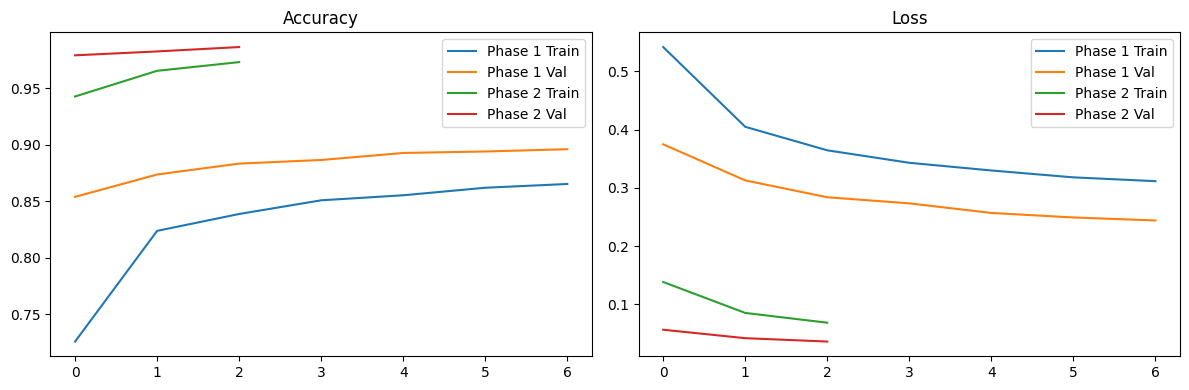

In [ ]:
# Plot training history
plot_history([history1, history2], ['Phase 1', 'Phase 2'])

# Conclusion

- Transfer Learning using VGG16 significantly improves performance.
- Data augmentation increases model generalization.
- Fine-tuning enhances accuracy further.
- The model successfully classifies images as Dog or Cat.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 165ms/step


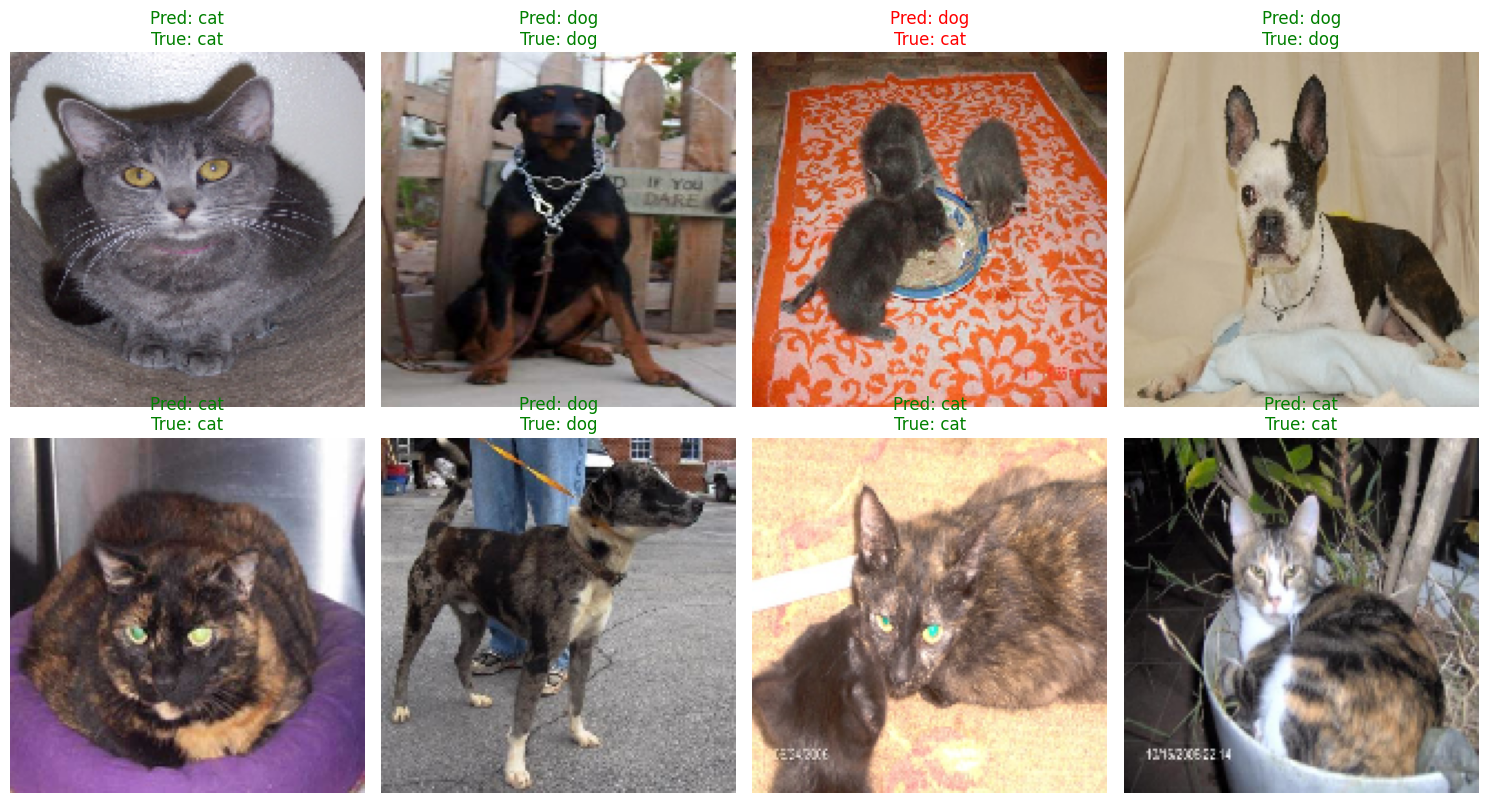

In [ ]:

def show_predictions(num_images=8):

    img_batch, label_batch = next(val_generator)
    predictions = model.predict(img_batch)
    predicted_classes = (predictions > 0.5).astype(int)


    plt.figure(figsize=(15, 8))
    for i in range(num_images):
        true_label = 'dog' if label_batch[i] == 1 else 'cat'
        pred_label = 'dog' if predicted_classes[i] == 1 else 'cat'

        plt.subplot(2, 4, i+1)
        plt.imshow(img_batch[i])
        plt.title(f"Pred: {pred_label}\nTrue: {true_label}",
                  color=("green" if pred_label == true_label else "red"))
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Show some predictions from validation data
show_predictions()


In [ ]:
# from google.colab import drive

# # Mount Google Drive
# drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# # Specify the path in Google Drive where you want to save the model
# model_save_path = '/content/drive/MyDrive/dog_cat_classification_model.h5'

# # Save the trained model to Google Drive
# model.save(model_save_path)

# print(f"Model saved at {model_save_path}")


Model saved at /content/drive/MyDrive/dog_cat_classification_model.h5
